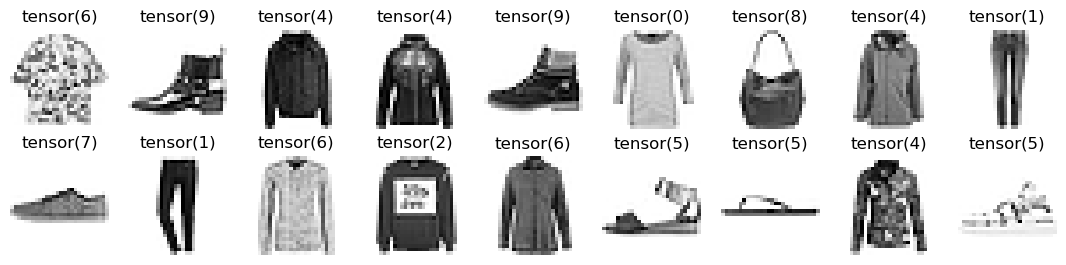

In [1]:
import torchvision
import torch
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt
import os

torch.manual_seed(1314)
trans = transforms.ToTensor()
train_data = torchvision.datasets.FashionMNIST(
    root="./DATASETS/MNIST", train=True, transform=trans, download=True)
test_data  = torchvision.datasets.FashionMNIST(
    root="./DATASETS/MNIST", train=False, transform=trans, download=True)
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 256  

train_dataloader = data.DataLoader(dataset = train_data,batch_size = BATCH_SIZE,shuffle = True)
test_dataloader  = data.DataLoader(dataset = test_data,batch_size = BATCH_SIZE)

def show_img(img,label,nrow,ncol,scale=1.5):
    fig,axes = plt.subplots(nrow,ncol, figsize=(ncol*scale,nrow*scale)) 
    axes = axes.flatten()
    for i,(img,ax) in enumerate(zip(img,axes)):
        ax.imshow(img.squeeze(),cmap="Greys")
        ax.set_title(label[i])
        ax.axis('off')
    plt.show()

x, y = next(iter(train_dataloader))
show_img(x,y,2,9)

In [2]:
class model(torch.nn.Module):
    def __init__(self,in_dims,out_dim):
        super().__init__()
        self.layers = torch.nn.modules.Sequential(
            torch.nn.Linear(in_dims,512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512,256),
            torch.nn.ReLU(),
            torch.nn.Linear(256,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,out_dim),
        )
    def forward(self,x):
        x = self.layers(x)
        return x

In [3]:
def softmax(x):
    x_exp = torch.exp(x)
    x_exp_sum = x_exp.sum(1,keepdims=True)
    return x_exp/x_exp_sum

def cross_entropy(y_hat,y):
    return -torch.log(y_hat[range(len(y_hat)),y])

def accuracy(y_hat,y):
    pred = y_hat.argmax(1)
    cmp = pred==y
    acc = cmp.sum()/len(y)
    print("Accuracy:%.3f"%(acc))
    return acc

def dropout(x,p):
    assert 0 <= p <= 1,"p >= 0 and <=1"
    if(p==1):
        return torch.zeros_like(x.shape)
    if(p==0):
        return x
    mask = (torch.rand(x.shape) > p).float()
    return mask * x /(1 - p)

def l2_penalty(w,p):
    return torch.pow(w,2).sum()*p/2

# aa = torch.tensor([[0.1,0.2],[0.1,0.2]])
# bb = torch.tensor([1,1])
# accuracy(aa,bb)

# y = torch.tensor([0,2])
# y_hat = torch.tensor([[0.1,0.2,0.7],[0.2,0.4,0.4]])
# print(y_hat[[0,1,],y])
# print(cross_entropy(y_hat,y))

In [4]:
torch.cuda.is_available()

False

In [5]:
# w = torch.normal(0,1,(28*28,10),requires_grad=True)
# b = torch.normal(0,1,(10,),requires_grad=True)
w = torch.normal(0,1,(28*28,10),requires_grad=True,device=device)
b = torch.normal(0,1,(10,),requires_grad=True,device=device)

In [6]:
n_epoch = 3
optimizer = torch.optim.SGD([w,b],0.001)
for epoch in range(n_epoch):
    for img,label in train_dataloader:
        img,label = img.to(device),label.to(device)
        img = img.flatten(1)
        y_hat = torch.matmul(img,w)+b
        y_hat = softmax(y_hat)
        loss = cross_entropy(y_hat,label) + l2_penalty(w,0.001)
        optimizer.zero_grad()
        loss.sum().backward()
        optimizer.step()
    for img,label in test_dataloader:
        img,label = img.to(device),label.to(device)
        img = img.flatten(1)
        y_hat = torch.matmul(img,w)+b
        y_hat = softmax(y_hat)
        accuracy(y_hat,label)
        break
        

Accuracy:0.656
Accuracy:0.746
Accuracy:0.762


In [7]:
n_epoch = 200
check_point_dir = os.path.join(os.getcwd(),'softmax_mnist.pth')
my_model = model(28*28,10).to(device)
if os.path.exists(check_point_dir):
    print("find the check_point, try to load to the module.")
    my_model.load_state_dict(torch.load(check_point_dir,map_location=device))
    print("Load successful")
optimizer = torch.optim.SGD(my_model.parameters(),0.001,weight_decay=0.001)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

In [8]:
best_acc = 0
no_optimize_count = 0
for epoch in range(n_epoch):
    my_model.train()
    for img,label in train_dataloader:
        img,label = img.to(device),label.to(device)
        img = img.flatten(1)
        pred = my_model(img)
        loss = criterion(pred,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    my_model.eval()
    for img, label in test_dataloader:
        with torch.no_grad():
            img,label = img.to(device),label.to(device)
            img = img.flatten(1)
            pred = my_model(img)
            pred = pred.softmax(1)
            acc = accuracy(pred,label)
            if(acc > best_acc):
                torch.save(my_model.state_dict(),'softmax_mnist.pth')
                print(f'saving current module. current_accuracy:{acc:.3f} last_accuracy:{best_acc:.3f}')
                best_acc = acc
                no_optimize_count = 0
            else:
                no_optimize_count += 1
            break 
    if(no_optimize_count > 10):
        print(f"no improving, best accuracy:{best_acc:.3f}")
        break
     

Accuracy:0.727
saving current module. current_accuracy:0.727 last_accuracy:0.000
Accuracy:0.828
saving current module. current_accuracy:0.828 last_accuracy:0.727
Accuracy:0.848
saving current module. current_accuracy:0.848 last_accuracy:0.828
Accuracy:0.852
saving current module. current_accuracy:0.852 last_accuracy:0.848
Accuracy:0.875
saving current module. current_accuracy:0.875 last_accuracy:0.852
Accuracy:0.879
saving current module. current_accuracy:0.879 last_accuracy:0.875
Accuracy:0.871
Accuracy:0.871
Accuracy:0.887
saving current module. current_accuracy:0.887 last_accuracy:0.879
Accuracy:0.883
Accuracy:0.875
Accuracy:0.887
Accuracy:0.883
Accuracy:0.891
saving current module. current_accuracy:0.891 last_accuracy:0.887
Accuracy:0.871
Accuracy:0.883
Accuracy:0.863
Accuracy:0.895
saving current module. current_accuracy:0.895 last_accuracy:0.891
Accuracy:0.883
Accuracy:0.895
Accuracy:0.895
Accuracy:0.898
saving current module. current_accuracy:0.898 last_accuracy:0.895
Accuracy:0

Accuracy:0.793


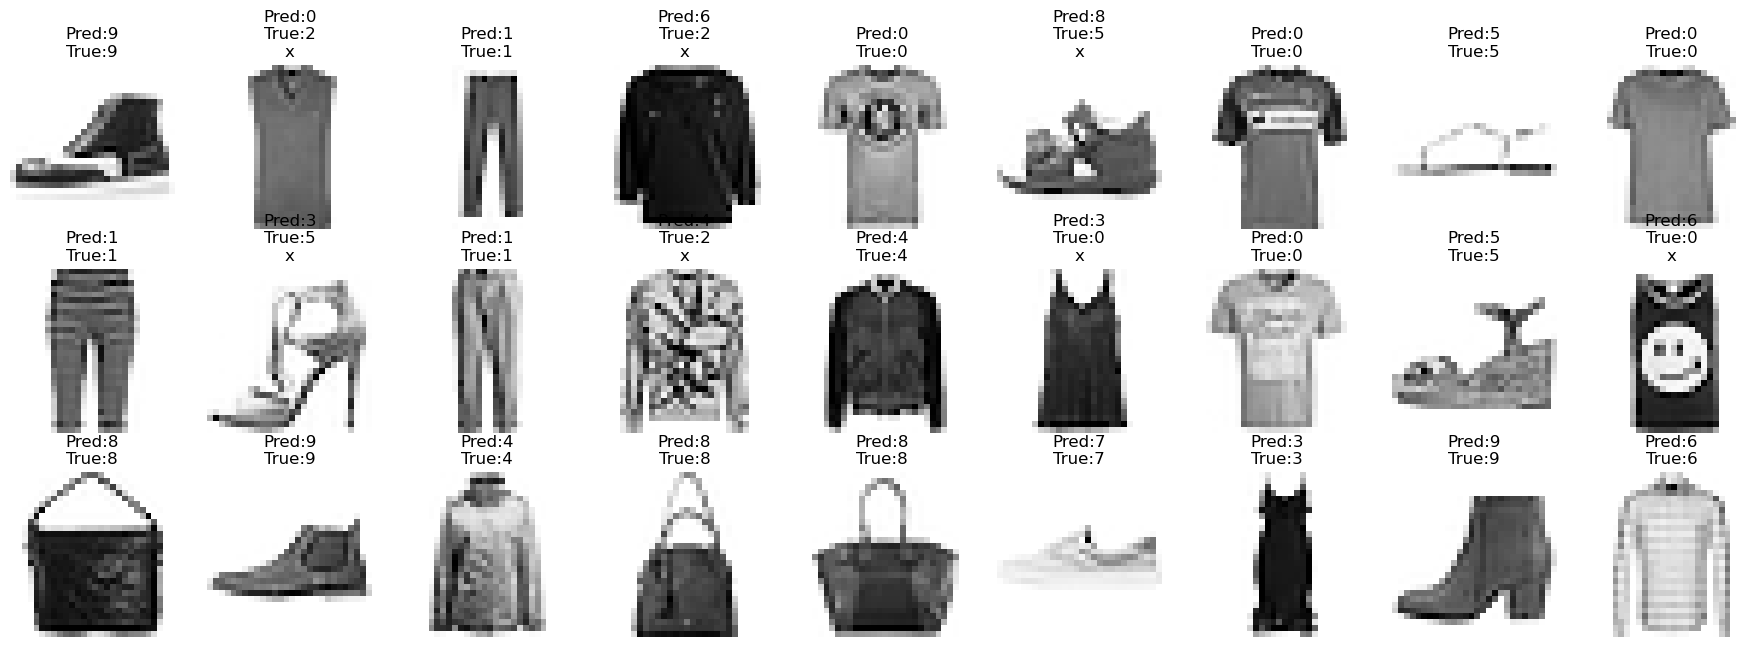

In [9]:
def pred_img(count): # using manual configuration to build model and predict the answer
    for img,label in train_dataloader:
        img,label = img.to(device),label.to(device)
        img_flatten = img.flatten(1)
        y_hat = torch.matmul(img_flatten,w)+b
        y_hat = softmax(y_hat)
        accuracy(y_hat,label)
        pred  = y_hat.argmax(1)
        title = ['Pred:' + str(int(i)) + '\nTrue:' + str(int(j)) + ('\nx' if int(i)!=int(j) else '') for i,j in zip(pred,label)]
        show_img(img.detach().cpu(),title,3,9,scale=2.5)
        count-=1
        if count == 0:
            return

pred_img(1)

Accuracy:0.938


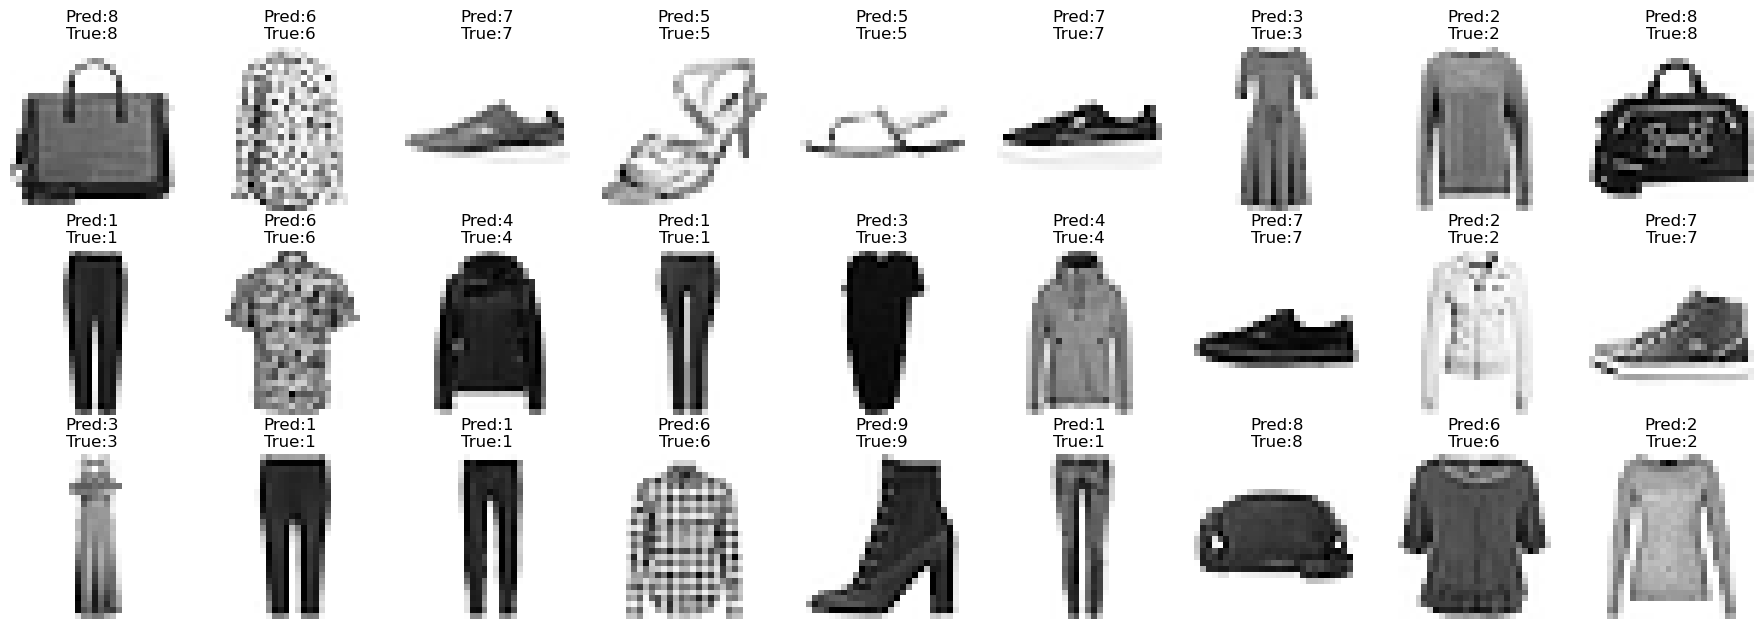

In [10]:
def pred_img(count): # using pytorch to build model and predict the answer
    for img,label in train_dataloader:
        my_model.eval()
        img,label = img.to(device),label.to(device)
        img_flatten = img.flatten(1)
        y_hat = my_model(img_flatten)
        y_hat = softmax(y_hat)
        accuracy(y_hat,label)
        pred  = y_hat.argmax(1)
        title = ['Pred:' + str(int(i)) + '\nTrue:' + str(int(j)) + ('\nx' if int(i)!=int(j) else '') for i,j in zip(pred,label)]
        show_img(img.detach().cpu(),title,3,9,scale=2.5)
        count-=1
        if count == 0:
            return

pred_img(1)